In [1]:
import os
import sys
sys.path.append('../..')

import pyedflib
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import signal
from imp import reload
import pandas as pd
import pywt
import readFiles
import databasePreparation
import preProcessing
import readEogertData
import math
from scipy import ndimage, misc
import json
import string
import neurokit2 as nk
import mne
import eeg_label

from visualization import plotEogElectrodesSignal, plotVertHorEOG, plotSaccadeSpanInSignal, plotTransformAndPeaks
from classificationUtils import peaksToBinary, peaksBinarySaccadeAnalysis, peaksBinaryToString, countEyeMovements, findPeaks
from evaluationUtils import countCorrectDetected, calculatePrecision, calculateRecall

In [2]:
# Reading the signals from the EDF file

fileName = 'C:/Users/Ricardo/source/enac-eog-analysis/src/labelAnnotation/EOGLabel-main/eegDataSet.edf'
channelsOfInterest = [64, 65, 66, 67, 68, 69]

# 64 - EXG1 = EOG D
# 65 - EXG2 = EOG G
# 66 - EXG3 = EOG D INTERNAL
# 67 - EXG4 = EOG G INTERNAL
# 68 - EXG5 = EOG H
# 69 - EXG6 = EOG B


# Reading the signals from the EDF file
try:
    f = pyedflib.EdfReader(fileName)
except FileNotFoundError as e:
    print(e)
    print('\n The {} file was not found.'.format(fileName))

# numSignals = f.signals_in_file

# These are the numbers of the channels that interest us
#channelsOfInterest = [256, 257, 258, 259]
numEyeChannels = len(channelsOfInterest)

# signal_labels = f.getSignalLabels()
# print(signal_labels)

# Creation of a zero array the correct dimensions.
eyesData = np.zeros((numEyeChannels, f.getNSamples()[0]))

for i, channel in enumerate(channelsOfInterest):
    eyesData[i, :] = f.readSignal(channel)

f.close()

freqSample = 2048

[] []
SaccadeInterval 4362.0
SaccadeInterval 8099.0
SaccadeInterval 6838.0
SaccadeInterval 6831.0
SaccadeInterval 4501.0
SaccadeInterval 2752.0
SaccadeInterval 1095.0
SaccadeInterval 4410.0
SaccadeInterval 2860.0
SaccadeInterval 4407.0
SaccadeInterval 2549.0
SaccadeInterval 1940.0
SaccadeInterval 8174.0
SaccadeInterval 7819.0
SaccadeInterval 2123.0
SaccadeInterval 4260.0
SaccadeInterval 8411.0
SaccadeInterval 4345.0
SaccadeInterval 2679.0
SaccadeInterval 1956.0
SaccadeInterval 2405.0
SaccadeInterval 2716.0
SaccadeInterval 2707.0
SaccadeInterval 1817.0
SaccadeInterval 10521.0
SaccadeInterval 4315.0
SaccadeInterval 1969.0
SaccadeInterval 7924.0
SaccadeInterval 2474.0
SaccadeInterval 2430.0
SaccadeInterval 4320.0
SaccadeInterval 2844.0
SaccadeInterval 4345.0
SaccadeInterval 8788.0
SaccadeInterval 4293.0
SaccadeInterval 1355.0
SaccadeInterval 346.0
SaccadeInterval 1978.0
SaccadeInterval 4315.0
SaccadeInterval 2612.0
SaccadeInterval 8456.0
SaccadeInterval 7571.0
SaccadeInterval 2463.0
Sacca

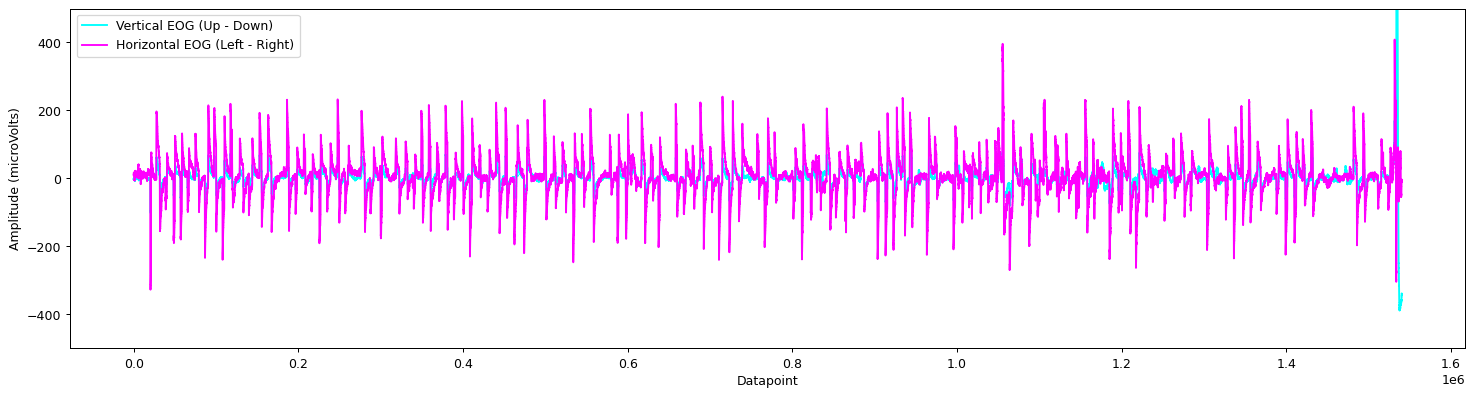

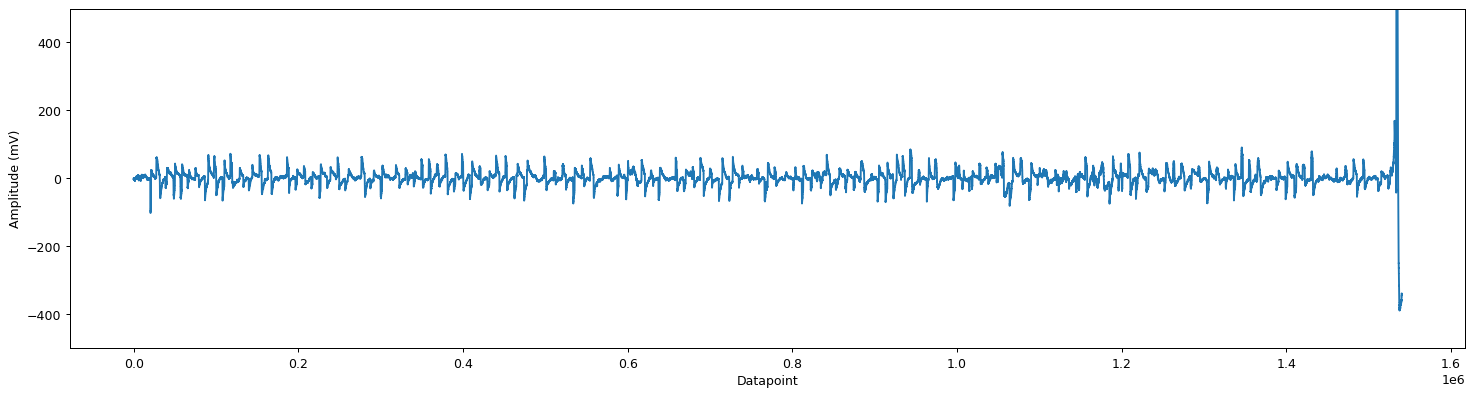

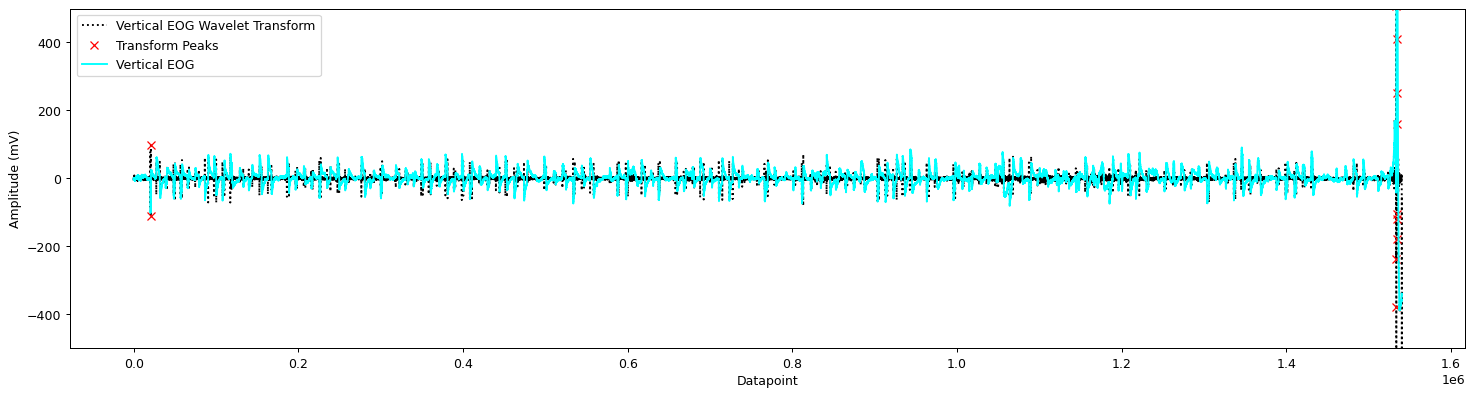

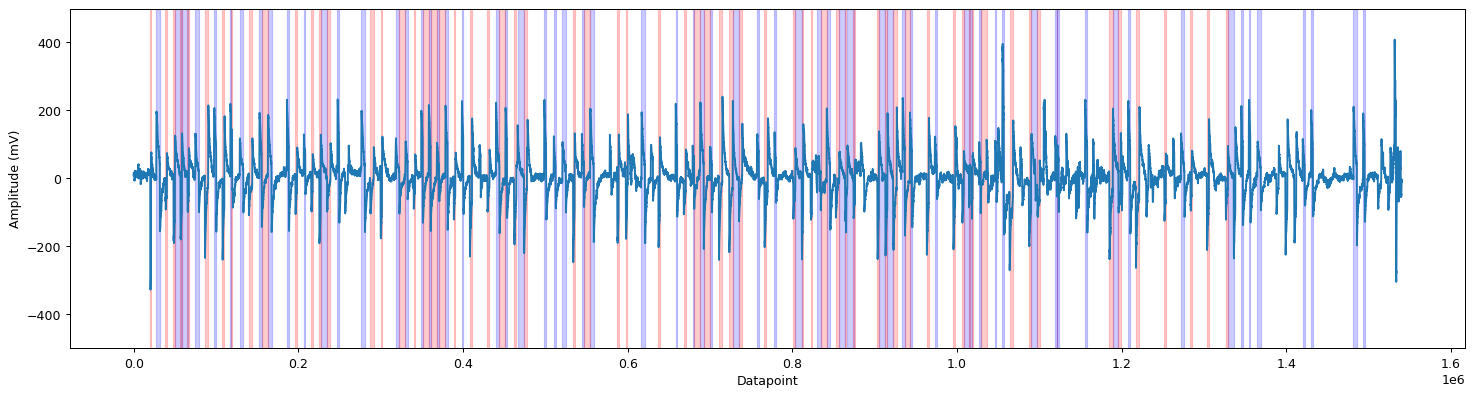

C:\Users\Ricardo\anaconda3\envs\ENAC_EOG_Detection\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


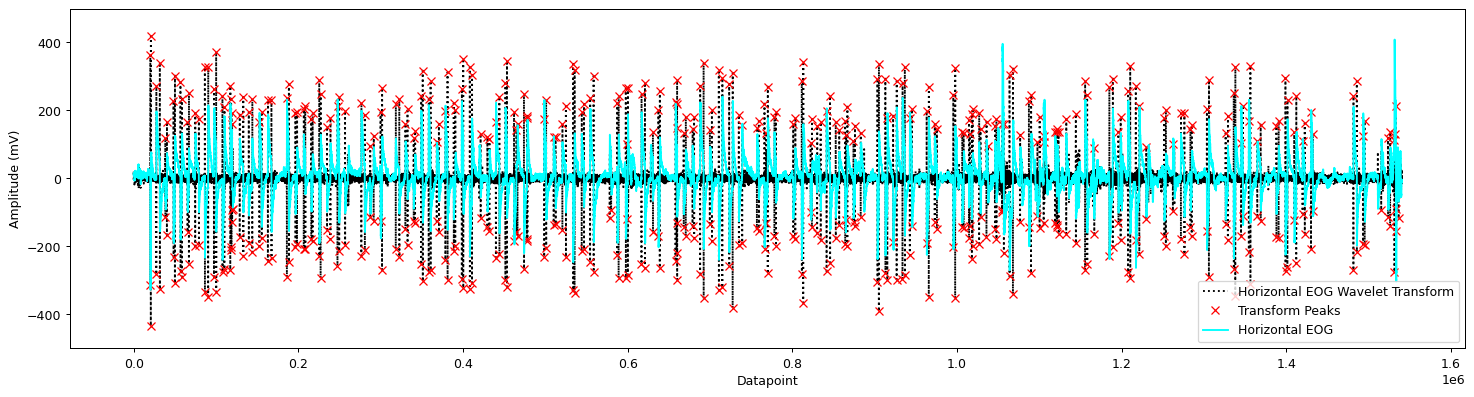

In [6]:
resultsPath = 'results/RI02_602/'
sectionName = 'WassimData'

verticalEOG, horizontalEOG = preProcessing.electrodesToVertHori(eyesData, 0, 1, 2, 3)

verticalEogDenoised = ndimage.median_filter(verticalEOG, size = 200)
horizontalEogDenoised = ndimage.median_filter(horizontalEOG, size = 200)

verticalEOG = verticalEogDenoised
horizontalEOG = horizontalEogDenoised

verticalEOG3 = np.reshape(verticalEOG, (len(verticalEOG),1))
horizontalEOG3 = np.reshape(horizontalEOG, (len(horizontalEOG),1))

coefVertMexHat, freqsVertMexHat = pywt.cwt(verticalEOG, 30, 'mexh')
coefHoriMexHat, freqsHoriMexHat = pywt.cwt(horizontalEOG, 30, 'mexh')

coefVertMexHat1 = np.reshape(coefVertMexHat, (len(coefVertMexHat[0]),1))
coefHoriMexHat1 = np.reshape(coefHoriMexHat, (len(coefHoriMexHat[0]),1))

#coefVertMexHat2 = preProcessing.zeroPadArtifacts(coefVertMexHat1, 70)

# Peakfinding

# Flatten the vectors so they can be used in the signal.find_peaks function
vertCwt = coefVertMexHat1.flatten()
horiCwt = coefHoriMexHat1.flatten()

# Thresholds of the saccade peaks
peaksHeight = np.array([90, 600])
minSaccadeDistance = 100

# Returns peaks' indexes and their properties in a dict
# The peaks are detected in the module version of signal in order to find the negative peaks as well
peaksV = findPeaks(vertCwt, peaksHeight[0], peaksHeight[1], minSaccadeDistance)
peaksH = findPeaks(horiCwt, peaksHeight[0], peaksHeight[1], minSaccadeDistance)

vertPeaksBinary = peaksToBinary(peaksV, vertCwt)
horiPeaksBinary = peaksToBinary(peaksH, horiCwt)

upSaccadeStartEnd, downSaccadeStartEnd = peaksBinarySaccadeAnalysis(vertPeaksBinary, jumpIntervalThreshold=500, saccadeLowerThreshold=500, saccadeUpperThreshold=8000)
print(upSaccadeStartEnd,downSaccadeStartEnd)
leftSaccadeStartEnd, rightSaccadeStartEnd = peaksBinarySaccadeAnalysis(horiPeaksBinary, jumpIntervalThreshold=500, saccadeLowerThreshold=500, saccadeUpperThreshold=8000)
print('Left Saccades', leftSaccadeStartEnd, '\n', 'Right Saccade')

# Detecting saccades candidates and blink candidates
vertPeaksString = peaksBinaryToString(vertPeaksBinary[2])
horiPeaksString = peaksBinaryToString(horiPeaksBinary[2])

up, down, left, right, blinks = countEyeMovements(vertPeaksString, horiPeaksString)

# All the plots

plotVertHorEOG(verticalEogDenoised, horizontalEogDenoised,  mode='both')

#plt.savefig('{}{}_eog.png'.format(resultsPath, plotName))
plt.show()

plotSaccadeSpanInSignal(verticalEOG, upSaccadeStartEnd, downSaccadeStartEnd)
plt.show()

plotTransformAndPeaks(coefVertMexHat1, peaksV, verticalEOG, 'Vertical')
#plt.savefig('{}{}_eogVTransform.png'.format(resultsPath,plotName))
plt.show()

plotSaccadeSpanInSignal(horizontalEOG, leftSaccadeStartEnd, rightSaccadeStartEnd)
plt.show()

plotTransformAndPeaks(coefHoriMexHat1, peaksH, horizontalEOG, 'Horizontal')
#plt.savefig('{}{}_eogHTransform.png'.format(resultsPath, plotName))
plt.show() 

# Saving the parts of the signal into .matfiles
#databasePreparation.arrayToMat(part, plotName)